# Predicting the Margin-of-Victory for the 2018 House Election

#### Task created and data supplied by Decision Desk HQ, analysis completed by Arianwyn Frank

Our task here, ladies and gentelman, is to predict the R-D Victory Margin for the winners of the 2018 US House of Representatives election seats. In this notebook I will not only be demonstrating my solution of the problem at hand, but also the trials I endured in order to reach my solution. 

My audience for this is (hopefully) my future employeers so I am going to keep a bit of whimsy within this notebook. However, I want you to know that if I was writing an article to the general public I would be much more formal. Some of my comments going forward are a stylistic choice that is created to entertain you guys, and should not be taken as a representation of an attempt to create a report targeted to the greater public.

## Step 1: Imports

I find it important to do my imports at the beginning so we can avoid periodically doing imports. In my opinion this just makes everything come out more smoothly. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.stats.outliers_influence import OLSInfluence

In [2]:
raw_data = pd.read_csv('DDHQ_Data_Exercise Aug 2023.csv')
copy = raw_data.copy()

## Step 2: Understanding and Cleaning Our Data

This is the portion in which we get all of our summary statistics in. We want to understand the correlations between our variables and the structure of our data.

Normally I would explore the meaning of each column, but the assignment PDF outlines our features for that, so it's unnecessary here. Further, DDHQ was nice enough to give me pretty much squeaky clean data so thanks guys!

In [3]:
#print(raw_data.isnull().sum())

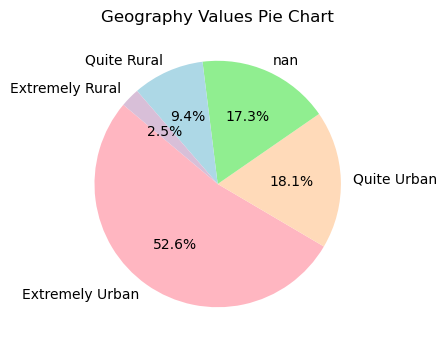

In [4]:
# Defining my typical color palette, I'm a sucker for a good pastel
pastel_colors = ['#FFB6C1', '#FFDAB9', '#90EE90', '#ADD8E6', '#D8BFD8', '#B0E0E6']

plt.figure(figsize=(5, 4))
value_counts = raw_data['Geography'].value_counts(dropna=False)
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=pastel_colors)
plt.title('Geography Values Pie Chart')
plt.show()

In this case, it looks like Geography is missing some columns. However, after reviewing the documentation and chart above, I think it's pretty clear that NaN values are supposed to represent a lack of a leaning rather than a lack of data. Because of this, I think it is best to recode the NaN values to have a more representative label. 

For the record, I do think it is a weak spot in the documentation that it does not specify all of the values that Geography (and a few other variables) can take on, since there is clearly a unified classification within this feature. Just something to think about for the future!

In [5]:
# Giving NaN a more indicitive label

raw_data['Geography'].fillna('Neutral', inplace=True)

### Step 2.5: Sorting Features and Encoding

We also need to take a look at our dataset's features. I'm going to start by eliminating chamber because it's the same for all of them. I'm also going to drop the Race ID column because we have all of the information in it stored within Chamber, Year, and State. Lastly, I will encode all of our categorical variables because that's how computers/math works. I chose Label Encoder for this problem for cleanliness and simplicity, but in a professional setting I would probably use OneHotEncoder since it's asymptotically slightly more precise.

In [6]:
raw_data.drop(columns=['Chamber', 'Race ID'], inplace=True)

filtered_data = raw_data

In [7]:
categorical_vars = ['State', 'Incumbent Running?', 'Geography']

label_encoder = LabelEncoder()

for column in categorical_vars:
    filtered_data[column] = label_encoder.fit_transform(raw_data[column])

# this is a secret tool that will help us later
knn_data = filtered_data.copy()

## Step 3: Thinking about models

I am going to begin by visualizing the correlations to determine if we have any strongly correlated and/or dependent variables. 

In [8]:
filtered_data['R-D Victory Margin'] = filtered_data['R-D Victory Margin'].replace('???', np.nan)
filtered_data['R-D Victory Margin'] = filtered_data['R-D Victory Margin'].astype(float)
filtered_data.dropna(subset=['R-D Victory Margin'], inplace=True)

In [9]:
correlation_matrix = filtered_data.corr()

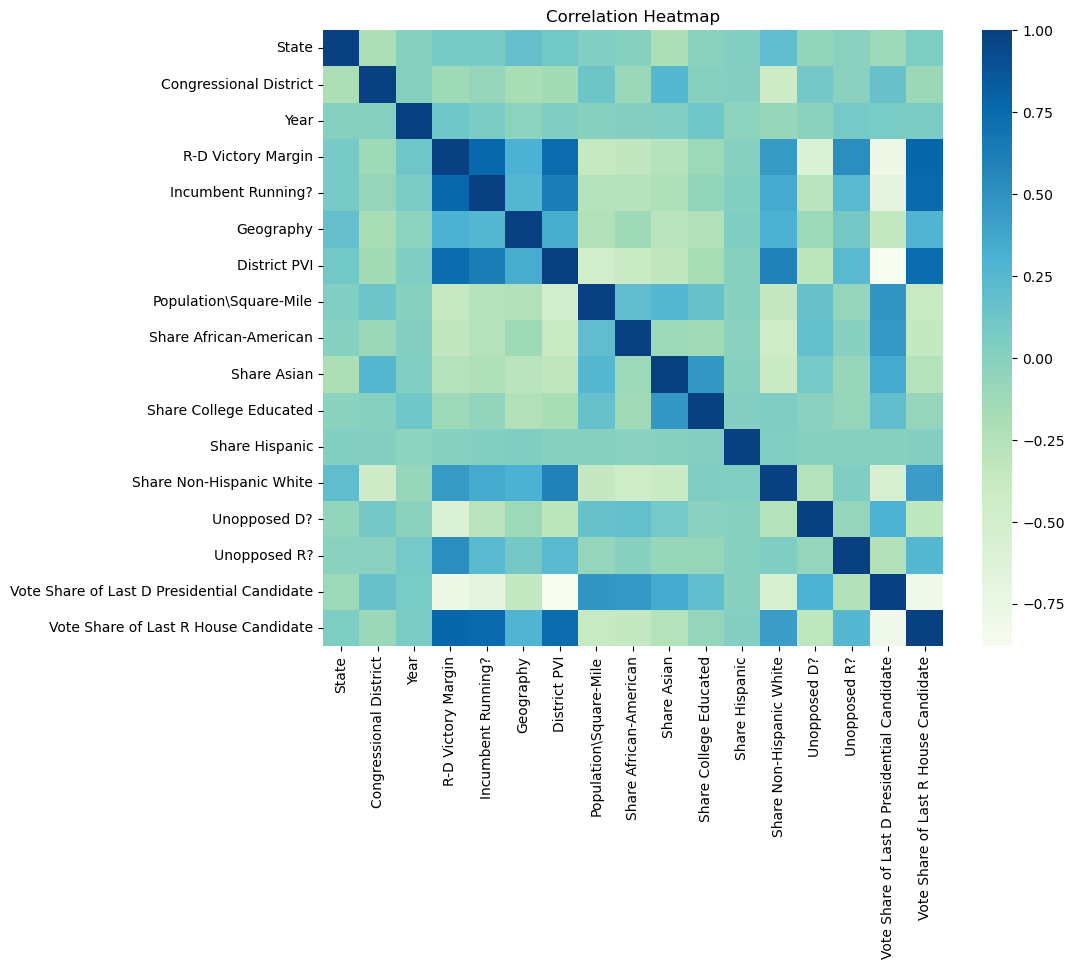

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, fmt=".2f", cmap="GnBu")
plt.title('Correlation Heatmap')
plt.show()

This heatmap is super telling and highlights my primary concerns. It seems a lot of the variables share correlations, so that's something I'm going to have to watch out before when making my model. I do want to specify that it also makes sense why basically all of these would have a relationship to one another. For example, it makes a lot of sense that "Incumbent Running?" would be correlated with "Vote Share of last R/D Candidate", as often the last R/D candidate was the incumbent. 

I also apologize for the large figure size, because we have so many features at work, making it any smaller makes it pretty much unreadable.

## Step 4: Modeling

It's time to model! In this notebook I plan to keep all iterations of models I have created unless the complexity starts getting really bad, but I do not expect that to be the case. 

In [11]:
filtered_plus_target = filtered_data

X = filtered_data.drop(columns=['R-D Victory Margin'])
y = filtered_plus_target['R-D Victory Margin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

### Model V1: Linear 

I feel like linear modeling is always the first step to achieving greatness. Just because you don't think the easy version will work doesn't mean you can't try it!

In [12]:
model = sm.OLS(y_train, X_train_with_intercept)
results = model.fit()

y_pred = results.predict(X_test_with_intercept)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)
#print(results.summary())

511129278549296.44


Fun fact I actually have never done specifically statistical modeling in Python, only base level ML with skLearn so please enjoy me getting to do R-style diagnostics in Python for the first time. The future is now.

For initial thoughts, I'm happy about the R_Squared of 0.921, but very significantly noting the huge RMSE and AIC. It is clear from our summary that we have a lot of multicollinearity going on. In fact, it is so poinient that I'm not going to run any other summary statistics on this particular model. To fix this, we need some feature engineering. 

### Side mission: filtering our features

#### Filter method 1: Logic!

I want to create a model that only predicts races if they are running opposed. Thus, we can get rid of "Unopposed D" and "Unopposed R" because we can just write an if statement at the beginning of the model. Then, we can also get rid of all of the data in which individuals are running unopposed because we already know their outcome.

In [13]:
filtered_plus_target = filtered_plus_target.drop(filtered_plus_target[filtered_plus_target['Unopposed D?'] == 1].index)
filtered_plus_target = filtered_plus_target.drop(filtered_plus_target[filtered_plus_target['Unopposed R?'] == 1].index)
filtered_plus_target = filtered_plus_target.drop(columns = ['Unopposed D?', 'Unopposed R?'])

filtered_data = filtered_plus_target.drop(columns = ['R-D Victory Margin'])

In [14]:
X = filtered_data
y = filtered_plus_target['R-D Victory Margin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_with_intercept)
results = model.fit()

y_pred = results.predict(X_test_with_intercept)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)
#print(results.summary())

13.494897148820684


#### Filter method 2: Low P Value and Low Error

From our model, I decided to exclude any columns that have a P-Value above 0.05, and any columns that had a relatively large Std. Error. After composing a list of the "problem columns", I funny enough realized that the columns for each elimination category were the exact same.

In [15]:
drop_cols = ['State', 'Congressional District', 'Year', 'Share College Educated', 'Share Hispanic', 'Share Non-Hispanic White']
filtered_data = filtered_data.drop(columns = drop_cols)
filtered_plus_target = filtered_plus_target.drop(columns = drop_cols)

In [16]:
X = filtered_data
y = filtered_plus_target['R-D Victory Margin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_with_intercept)
results = model.fit()

y_pred = results.predict(X_test_with_intercept)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)
#print(results.summary())

13.442941249928882


#### Filter Method 3: Recursive Filtering

It seems we still have some colinearity happening in our dataset. Thus, a great way to eliminate this is with recursive filtering!

In [17]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select = 6)

rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Incumbent Running?', 'Geography', 'Share African-American',
       'Share Asian', 'Vote Share of Last D Presidential Candidate',
       'Vote Share of Last R House Candidate'],
      dtype='object')


In [18]:
filtered_data = filtered_data[selected_features]

In [19]:
selected_features = selected_features.append(pd.Index(['R-D Victory Margin']))
filtered_plus_target = filtered_plus_target[selected_features]

X = filtered_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_with_intercept)
results = model.fit()

y_pred = results.predict(X_test_with_intercept)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)
print(results.summary())

14.099869516442567
                            OLS Regression Results                            
Dep. Variable:     R-D Victory Margin   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     1510.
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:16:11   Log-Likelihood:                -7385.4
No. Observations:                1824   AIC:                         1.478e+04
Df Residuals:                    1817   BIC:                         1.482e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

Now it looks like we are getting somewhere! So far our model only has an R Squared of about 0.83, but the P values, errors, and colinearity all look pretty good. Our RMSE is also around 14.1, which isn't great but certainly could be worse. Now that our input data is pretty clean and our features have been engineered, it's time to dive deeper into the model itself. 

### Step 5: Exploring Model Statistics

Let's see how well our data fits our model. My favorite way to do this is by examining residuals.

In [20]:
residuals = y_test - y_pred

In [21]:
residuals_array = residuals.to_numpy().reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(residuals_array)

standardized_residuals = scaler.transform(residuals_array).flatten()

C:\Users\Arianwyn Frank\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


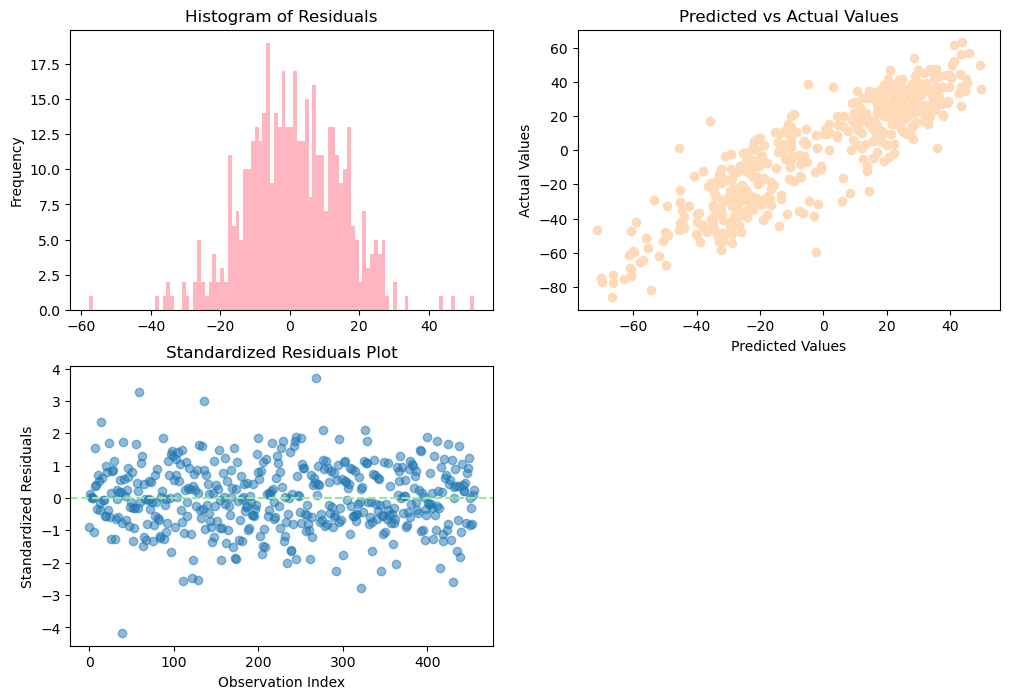

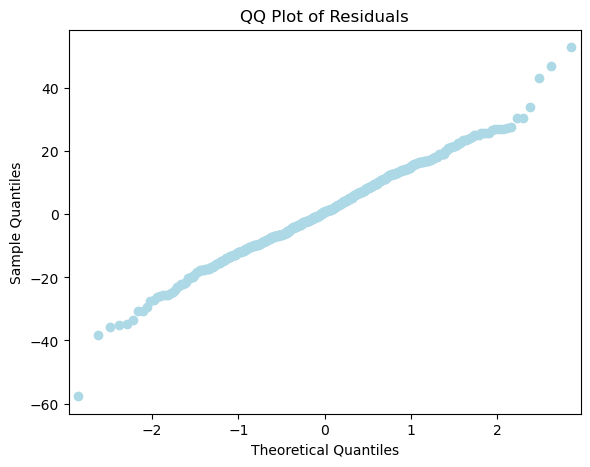

In [22]:
plt.figure(figsize=(12, 8))
pastel_colors = ['#FFB6C1', '#FFDAB9', '#90EE90', '#ADD8E6', '#D8BFD8', '#B0E0E6']

plt.subplot(2, 2, 1)
plt.hist(residuals, bins=100, color = '#FFB6C1')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.subplot(2, 2, 2)
plt.scatter(y_pred, y_test, color = '#FFDAB9')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')

plt.subplot(2, 2, 3)
plt.scatter(np.arange(len(standardized_residuals)), standardized_residuals, alpha=0.5)
plt.axhline(y=0, color='#90EE90', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals Plot')

sm.qqplot(residuals, fmt='o', markerfacecolor='#ADD8E6', markeredgecolor='#ADD8E6', color='#D8BFD8')
plt.title('QQ Plot of Residuals')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.4)
plt.show()

As you can see from above, our linear model has gotten about as good as we are going to get. Our residual plot and QQ plot evidence demonstrate that our model is homoscedastic. It seems that there might be a few outliers in our data, but overall I think the bigger issue is likely that our model type is wrong. Thus, I think it is high time that we up the complexity of our model.

### Step 6: Considering transforming the data

I figured now that we have significantly less noise, we should plot our data and see if we should be transforming it. To tell you the truth, I probably should have done this a bit earlier, but better late than never!

In [23]:
y_shifted = y - y.min()
y_log = np.log(y_shifted)

y_boxcox, lambda_value = boxcox(y_shifted + 1)

y_sqrt = np.sqrt(y_shifted)

C:\Users\Arianwyn Frank\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


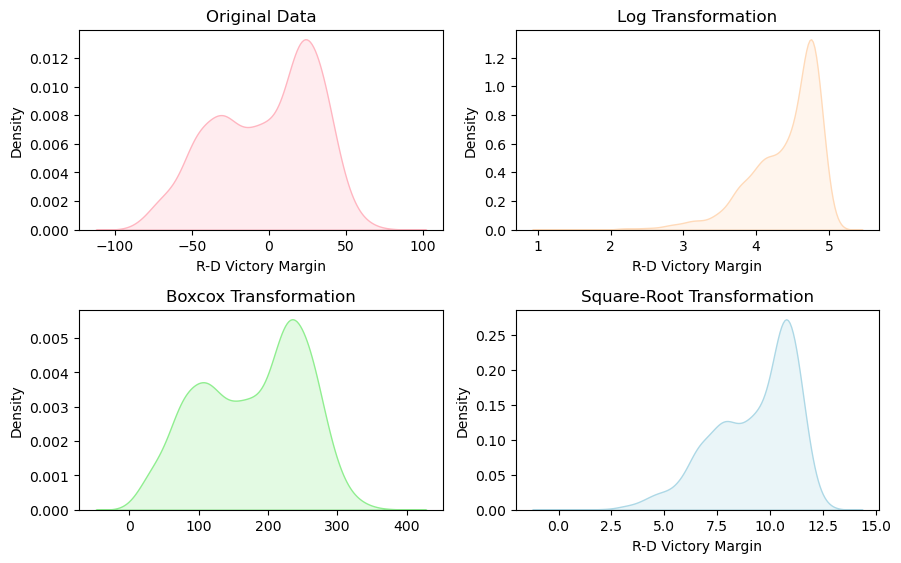

In [24]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
sns.kdeplot(y, shade=True, color='#FFB6C1')
plt.title('Original Data')
plt.ylabel('Density')

plt.subplot(2, 2, 2)
sns.kdeplot(y_log, shade=True, color='#FFDAB9')
plt.title('Log Transformation')
plt.ylabel('Density')

plt.subplot(2, 2, 3)
sns.kdeplot(y_boxcox, shade=True, color='#90EE90')
plt.title('Boxcox Transformation')
plt.ylabel('Density')

plt.subplot(2, 2, 4)
sns.kdeplot(y_sqrt, shade=True, color='#ADD8E6')
plt.title('Square-Root Transformation')
plt.ylabel('Density')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.4)
plt.show()

So it looks like our data gets a little bit more normal with a log transformation, but not then has a really heavy left skew. I'm going to thus attempt to improve my model to add more degrees of freedom.

In [25]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)

model = sm.OLS(y_train, X_poly)
results = model.fit()

#print(results.summary())

y_pred = results.predict(X_poly_test)
residuals = y_test - y_pred

residuals_array = residuals.to_numpy().reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(residuals_array)

standardized_residuals = scaler.transform(residuals_array).flatten()

C:\Users\Arianwyn Frank\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


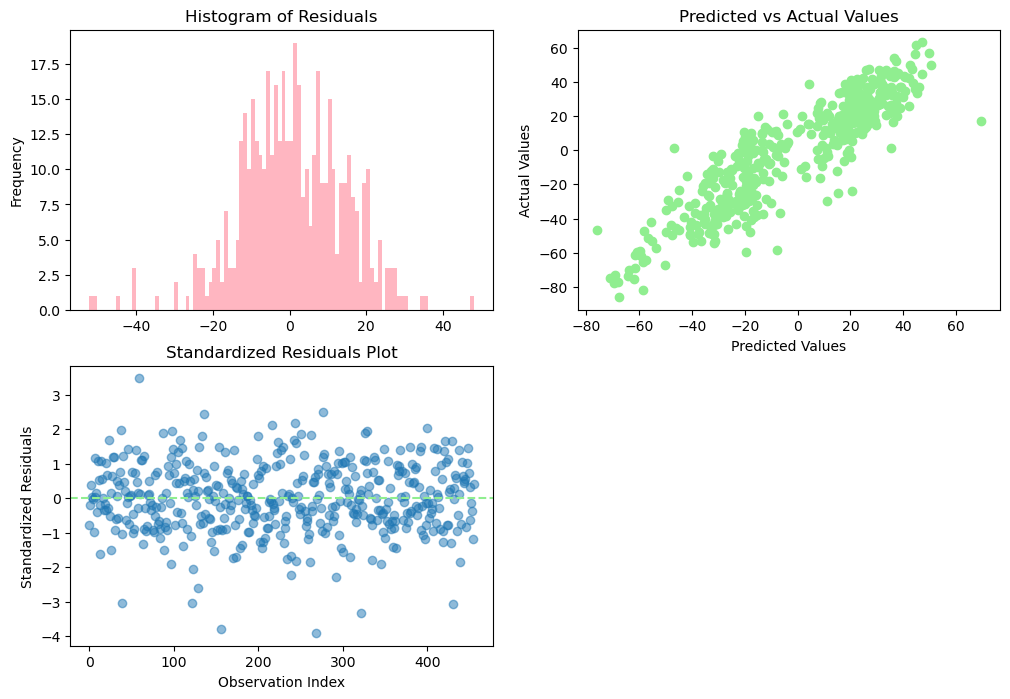

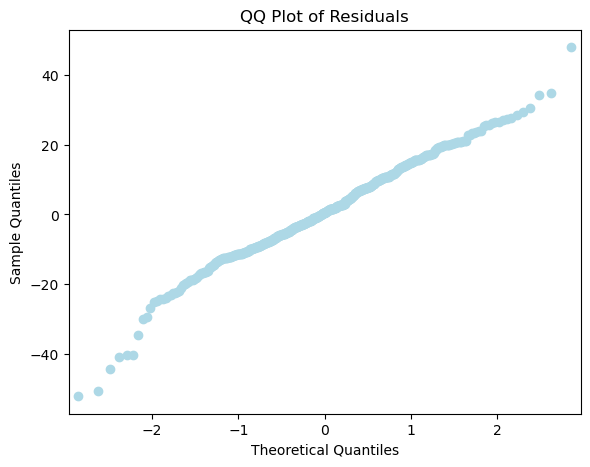

In [26]:
plt.figure(figsize=(12, 8))
pastel_colors = ['#FFB6C1', '#FFDAB9', '#90EE90', '#ADD8E6', '#D8BFD8', '#B0E0E6']

plt.subplot(2, 2, 1)
plt.hist(residuals, bins=100, color = '#FFB6C1')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.subplot(2, 2, 2)
plt.scatter(y_pred, y_test, color = '#90EE90')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')

plt.subplot(2, 2, 3)
plt.scatter(np.arange(len(standardized_residuals)), standardized_residuals, alpha=0.5)
plt.axhline(y=0, color='#90EE90', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals Plot')

sm.qqplot(residuals, markerfacecolor='#ADD8E6', markeredgecolor='#ADD8E6', color='#D8BFD8')
plt.title('QQ Plot of Residuals')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=10, wspace = 0.4)
plt.show()

In [27]:
y_pred_clipped = np.clip(y_pred, -100, 100)

mse = mean_squared_error(y_test, y_pred_clipped)
rmse = mse ** 0.5
print(rmse)

13.62775588531418


This looks much tighter, but there were a few outliers I had to remove with y_pred_clipped. Overall, looking at the graphs, I feel like the polynomial one is better, but I would have to preform a hypothesis test to be sure about that. 

In terms of linear and polynomial regression, I feel like these models have run their course and are about as good as they are going to get. The future of this doc is going to be briefly addressing a couple other models. 

### Model V2: kNN

kNN is alwys a good choice if you have kind of weird data, so I thought it would certainly be worth a try here. 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsRegressor(n_neighbors=10)
results = knn_model.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)
residuals = y_test - y_pred
rmse = mean_squared_error(y_test, y_pred, squared=False)
std_residuals = residuals / rmse

13.59510414271681


C:\Users\Arianwyn Frank\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


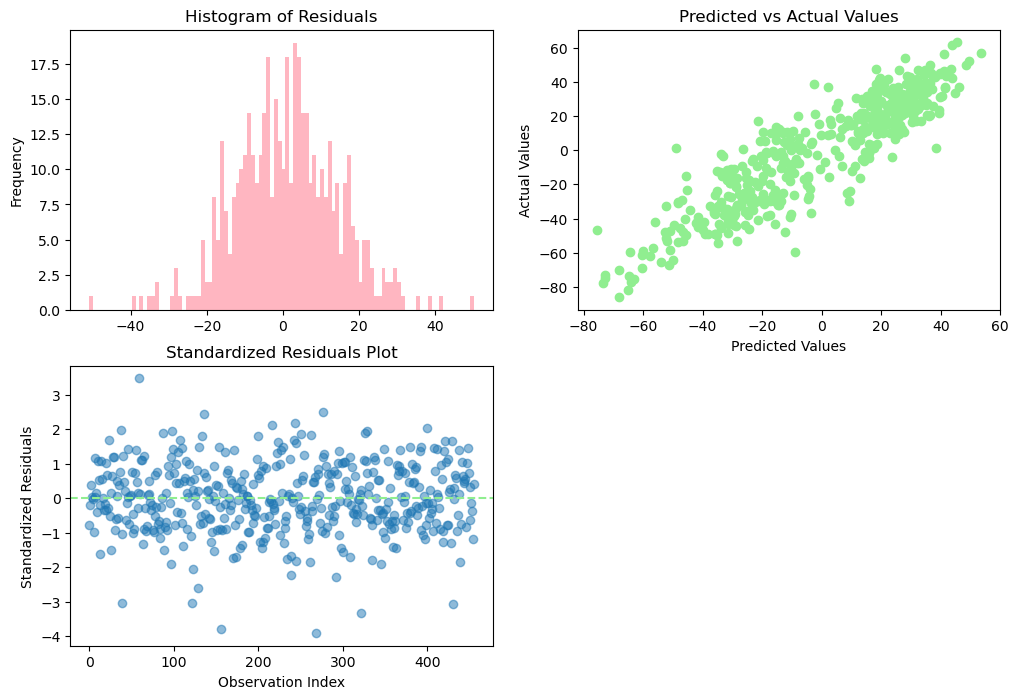

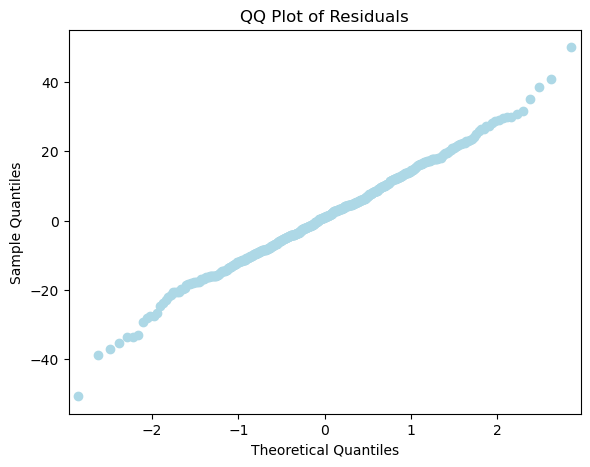

In [29]:
print(rmse)
plt.figure(figsize=(12, 8))
pastel_colors = ['#FFB6C1', '#FFDAB9', '#90EE90', '#ADD8E6', '#D8BFD8', '#B0E0E6']

plt.subplot(2, 2, 1)
plt.hist(residuals, bins=100, color = '#FFB6C1')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.subplot(2, 2, 2)
plt.scatter(y_pred, y_test, color = '#90EE90')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')

plt.subplot(2, 2, 3)
plt.scatter(np.arange(len(standardized_residuals)), standardized_residuals, alpha=0.5)
plt.axhline(y=0, color='#90EE90', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals Plot')

sm.qqplot(residuals, markerfacecolor='#ADD8E6', markeredgecolor='#ADD8E6', color='#D8BFD8')
plt.title('QQ Plot of Residuals')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=10, wspace = 0.4)
plt.show()

This model seems to beat the linear regression quite substantially. Again, I'd have to do a test, but I'm quite happy with the above figures and RMSE. 

# Predicting values
## Final model: kNN

We have come to the portion of our model in which we actually get to predict the R-D Victory Margin value! Recall that our model is a little weird because we filter out unopposed races. I'm also going to re-read in the data just to make sure we have a super clean slate. If I were to be submitting a model I would likely include this section separate.

In [30]:
# squeaky clean data
knn_data['R-D Victory Margin'] = knn_data['R-D Victory Margin'].replace('???', np.nan)
df = knn_data[knn_data['R-D Victory Margin'].isna()]

# filtering
selected_features = ['Incumbent Running?', 'Geography', 'Share African-American',
       'Share Asian', 'Vote Share of Last D Presidential Candidate',
       'Vote Share of Last R House Candidate']

train = df[selected_features]
train_scaled = scaler.fit_transform(train)
      
# predicting using the model we just made
predicted_values = knn_model.predict(train_scaled)

# putting the predicted values back
knn_data.loc[df.index, 'R-D Victory Margin'] = predicted_values

In [31]:
# keep in mind this data does not have 
knn_data['Race ID'] = copy['Race ID']
knn_data['Chamber'] = copy['Chamber']

# Now shown in Workbook!
#knn_data.to_csv('Arianwyn_Predictions.csv', index=False)

# Final Remarks

As you can see above, the model I created works pretty okay and utilizes a variety of approaches to solve my problem. This workbook includes topics such as data investigation, feature selection/analysis, linear regression, polynomial regression, k-Nearest Neighbors, summary statistic analysis, model preformance metrics, visualization, data transformations, and more. I hope you can not only see how much heart and soul I have put into this project, but also how analytically I approach problem-solving. As we wrap up on the coding portion, I do want to make note of a few things I would do to improve my model in the future. 

#### 1) Attempt Neural Network Model
This method is a bit beyond the scope for this project, but in general neural networks would be a great (and complex) way to solve this problem. 

#### 2) Fine-Tuning kNN (see: K-Folds Cross-Validation)
I didn't fine tune the kNN model much, but if I were genuinely making this model for a client or company, I would surely incorporate k-folds or another cross-validation technique into my program. 

#### 3) More Wholistic Visualization
In general I like to visualize my data in excruciating detail. Thus, to make myself even more familiar with the data I would probably graph each feature just to get a feel for distribution and the like. 

#### 4) More Data
As I'm sure you're aware, more data is (almost) always helpful! Thus, I could see myself factoring in datasets that include features such as the amount of money the candidate has spent on their campaign or the number of rally attendees. The latter number would be kind of hard to obtain reliably but I digress. I would also assume that the candidates' demographic information would be a pretty relevant predictor, but that's also pretty morally ambigouos so I would definitely have to put a lot of thought and research into that decision. 

This isn't quite along the same thread, but I think this data would be super interesting to cross reference with the US Senate. Would the model improve or worsen with that data also training my model?



## Thank you

Lastly, I just want to thank you for your time and the opportunity. I have admired DDHQ for a long time and your technical prompt certainly lived up to that standard. I'm always telling people that I wish more companies would give me a chance to showcase my talents via my work, and I appreciate that you guys are taking the time to do just that. 

I look forward to meeting with you all again!